In [2]:
import os
import imageio
import matplotlib.pyplot as plt
import cv2
%matplotlib widget
%load_ext autoreload
%autoreload 2
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    clean_degree_4,
)
import scipy
from amftrack.pipeline.functions.image_processing.node_id import remove_spurs
from amftrack.pipeline.functions.image_processing.extract_skel import remove_component, remove_holes
import numpy as np

c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
images_path = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\JAAP\Transport setup 4 x NileRed\selection"
files = os.listdir(images_path)

In [4]:
len(files)

360

In [5]:
images = [imageio.imread(os.path.join(images_path,file)) for file in files]

C:\Users\coren\AppData\Local\Temp\ipykernel_18724\3253156887.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(os.path.join(images_path,file)) for file in files]


In [6]:
def segment(images):
    average_proj = np.mean(np.array(images),axis=0)
    segmented = average_proj>10
    segmented = remove_holes(segmented)
    segmented = segmented.astype(np.uint8)
    connected = remove_component(segmented,min_size=4000)
    connected = connected.astype(np.uint8)
    skeletonized = cv2.ximgproc.thinning(np.array(connected, dtype=np.uint8))
    skeleton = scipy.sparse.dok_matrix(skeletonized)
    nx_graph, pos = generate_nx_graph(from_sparse_to_graph(skeleton))
    nx_graph, pos = remove_spurs(nx_graph, pos,threshold = 20)
    # nx_graph = clean_degree_4(nx_graph, pos)[0]
    return(skeletonized,nx_graph,pos)
skeletonized,nx_graph_pruned,pos = segment(images)

c:\users\coren\documents\phd\code\amftrack\amftrack\pipeline\functions\image_processing\extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


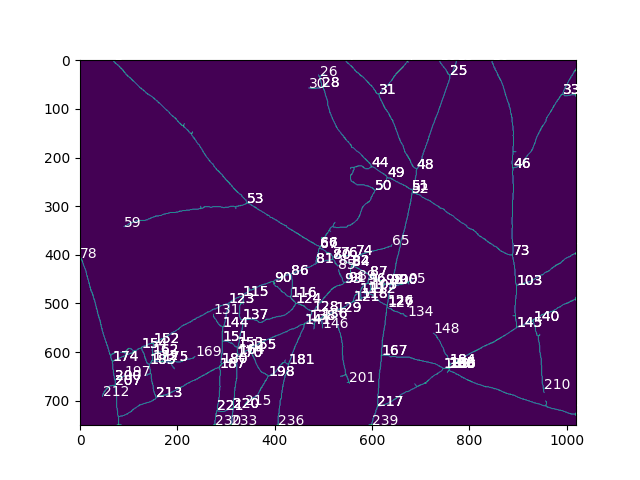

In [7]:
fig, ax = plt.subplots()
ax.imshow(skeletonized)
for edge in list(nx_graph_pruned.edges):
    ax.text(*np.flip(pos[edge[0]]),str(edge[0]),color="white")
    ax.text(*np.flip(pos[edge[1]]),str(edge[1]),color="white")

In [8]:
from random import choice
# edge = choice(list(nx_graph_pruned.edges))
edge=(73,46)

In [9]:
len(nx_graph_pruned.get_edge_data(*edge)['pixel_list'])

180

In [10]:
from amftrack.pipeline.functions.image_processing.extract_width_fun import generate_pivot_indexes, compute_section_coordinates
from skimage.measure import profile_line

def extract_section_profiles_for_edge(
    edge: tuple,
    pos: dict,
    raw_im : np.array,
    nx_graph,
    resolution=5,
    offset=4,
    step=15,
    target_length=120,
) -> np.array:
    """
    Main function to extract section profiles of an edge.
    Given an Edge of Experiment at timestep t, returns a np array
    of dimension (target_length, m) where m is the number of section
    taken on the hypha.
    :param resolution: distance between two measure points along the hypha
    :param offset: distance at the end and the start where no point is taken
    :param step: step in pixel to compute the tangent to the hypha
    :target_length: length of the section extracted in pixels
    :return: np.array of sections, list of segments in TIMESTEP referential
    """
    pixel_list = nx_graph.get_edge_data(*edge)['pixel_list']
    offset = max(
        offset, step
    )  # avoiding index out of range at start and end of pixel_list
    pixel_indexes = generate_pivot_indexes(
        len(pixel_list), resolution=resolution, offset=offset
    )
    list_of_segments = compute_section_coordinates(
        pixel_list, pixel_indexes, step=step, target_length=target_length + 1
    )  # target_length + 1 to be sure to have length all superior to target_length when cropping
    # TODO (FK): is a +1 enough?
    images = {}
    l = []
    for i, sect in enumerate(list_of_segments):
        im = raw_im
        point1 = np.array([sect[0][0], sect[0][1]])
        point2 = np.array([sect[1][0], sect[1][1]])
        profile = profile_line(im, point1, point2, mode="constant")[:target_length]
        profile = profile.reshape((1, len(profile)))
        # TODO(FK): Add thickness of the profile here
        l.append(profile)
    return np.concatenate(l, axis=0), list_of_segments

In [11]:
slices, segments = extract_section_profiles_for_edge(
    edge,
    pos,
    images[0],
    nx_graph_pruned,
    resolution=1,
    offset=4,
    step=15,
    target_length=10,
)

In [12]:
def plot_segments_on_image(segments,ax):
    for (point1, point2) in segments:
        ax.plot(
                [point1[1], point2[1]],  # x1, x2
                [point1[0], point2[0]],  # y1, y2
                color="red",
                linewidth=2,
            )

Text(0.5, 1.0, 'Slices taken along one hypha')

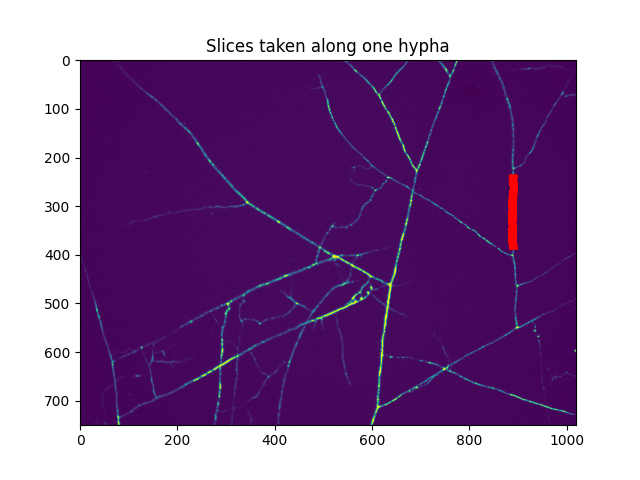

In [13]:
from matplotlib.pyplot import figure
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    plot_edge,
)

from amftrack.util.geometry import generate_index_along_sequence

fig, ax = plt.subplots()
ax.imshow(images[0])
plot_segments_on_image(segments,ax)
plt.title("Slices taken along one hypha")

In [13]:
(37*60+7)/16420

0.1356272838002436

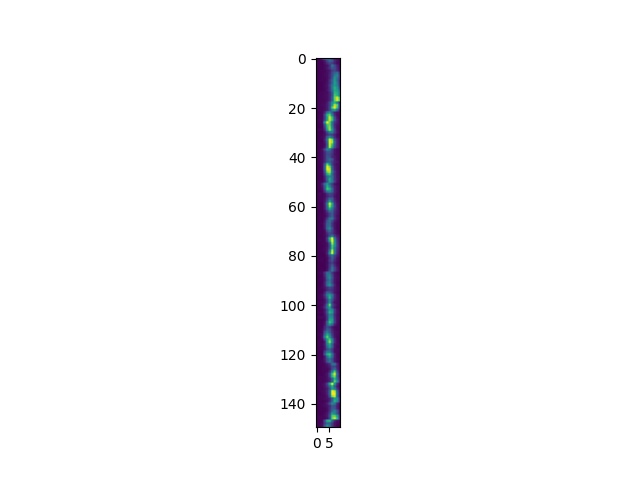

In [14]:
fig, ax = plt.subplots()
ax.imshow(slices)

In [15]:
kymo_line = np.mean(slices,axis=1)

In [16]:
kymo = []
for image in images:
    slices, segments = extract_section_profiles_for_edge(
        edge,
        pos,
        image,
        nx_graph_pruned,
        resolution=1,
        offset=4,
        step=15,
        target_length=10,
    )
    kymo_line = np.mean(slices,axis=1)
    kymo.append(kymo_line)

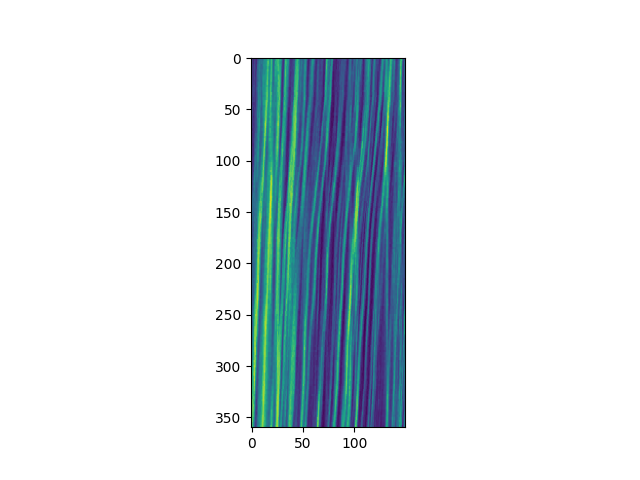

In [17]:
kymo = np.array(kymo)
fig, ax = plt.subplots()
ax.imshow(kymo)

In [63]:
import cv2 as cv
W = 30          # window size is WxW
C_Thr = 0.8   # threshold for coherency
time_pixel_size = 0.10 #s.pixel
space_pixel_size = 1.725*2 #um.pixel
intensity_volume_factor = 1 #um**3.intensity-unit

def calcGST(inputIMG, w):
    img = inputIMG.astype(np.float32)
    imgDiffX = cv.Sobel(img, cv.CV_32F, 1, 0, 3)
    imgDiffY = cv.Sobel(img, cv.CV_32F, 0, 1, 3)
    imgDiffXY = cv.multiply(imgDiffX, imgDiffY)
    
    imgDiffXX = cv.multiply(imgDiffX, imgDiffX)
    imgDiffYY = cv.multiply(imgDiffY, imgDiffY)
    J11 = cv.boxFilter(imgDiffXX, cv.CV_32F, (w,w))
    J22 = cv.boxFilter(imgDiffYY, cv.CV_32F, (w,w))
    J12 = cv.boxFilter(imgDiffXY, cv.CV_32F, (w,w))
    tmp1 = J11 + J22
    tmp2 = J11 - J22
    tmp2 = cv.multiply(tmp2, tmp2)
    tmp3 = cv.multiply(J12, J12)
    tmp4 = np.sqrt(tmp2 + 4.0 * tmp3)
    lambda1 = 0.5*(tmp1 + tmp4)    # biggest eigenvalue
    lambda2 = 0.5*(tmp1 - tmp4)    # smallest eigenvalue
    imgCoherencyOut = cv.divide(lambda1 - lambda2, lambda1 + lambda2)
    imgOrientationOut = cv.phase(J22 - J11, 2.0 * J12, angleInDegrees = True)
    imgOrientationOut = 0.5 * imgOrientationOut
    return imgCoherencyOut, imgOrientationOut

imgcrop = kymo
imgCoherency, imgOrientation = calcGST(imgcrop, W)

In [64]:
nans = np.empty(imgOrientation.shape)
nans.fill(np.nan)
real_movement = np.where(imgCoherency>C_Thr,imgOrientation,nans)

speeds = np.tan((np.nanmean(real_movement,axis=1)-90)/180*np.pi)*space_pixel_size/time_pixel_size #um.s-1
nans = np.empty(speeds.shape)
nans.fill(np.nan)
speeds = np.where(speeds<20,speeds,nans)
nans = np.empty(speeds.shape)
nans.fill(np.nan)
speeds = np.where(speeds>-20,speeds,nans)
import numpy as np

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

y= speeds
nans, x= nan_helper(y)
y[nans]= np.interp(x(nans), x(~nans), y[~nans])
speeds=y

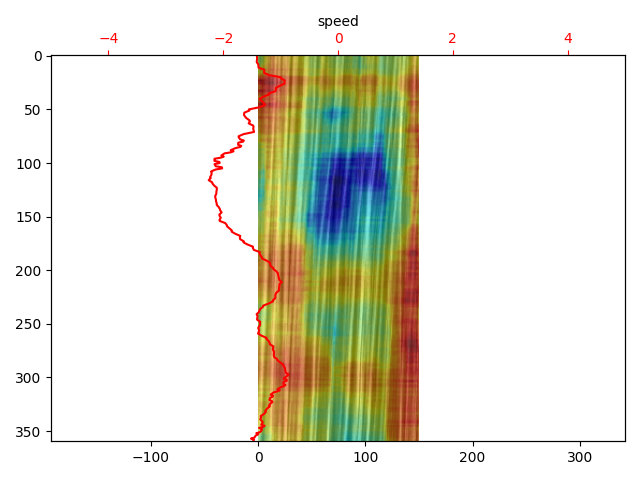

In [66]:
fig, ax = plt.subplots()
ax.imshow(imgcrop,cmap="gray")
ax2 = ax.twiny()
# ax2.plot(np.tan((np.mean(imgOrientation,axis=1)-90)/180*np.pi),range(len(np.mean(imgOrientation,axis=1))),color = "red")
ax2.plot(speeds,range(len(speeds)),color = "red")

ax2.tick_params(axis='x', colors='red')
ax2.set_xlabel('speed')

ax.imshow(imgOrientation*(imgCoherency>C_Thr),alpha=0.5,cmap="jet")
ax2.set_xlim((-5,5))

plt.tight_layout()

In [21]:
kymo.shape

(360, 150)

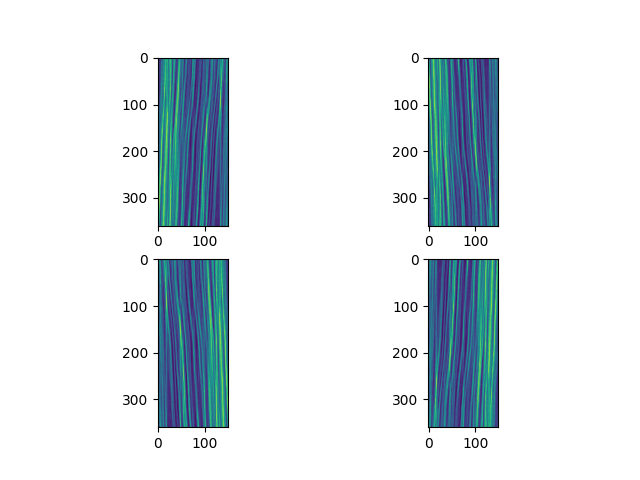

In [44]:
A = kymo[:,:]
B = np.flip(A,axis=0)
C = np.flip(A,axis=1)
D = np.flip(B,axis=1)
fig, axs = plt.subplots(2,2)
axs[0][0].imshow(A)
axs[0][1].imshow(B)
axs[1][0].imshow(C)
axs[1][1].imshow(D)

In [45]:
tiles = [[D,B,D],[C,A,C],[D,B,D]]
tiles = [cv2.hconcat(imgs) for imgs in tiles]
tiling_for_fourrier = cv2.vconcat(tiles)
# tiling_for_fourrier = [
#             [cv2.vconcat(imgs[::2]), cv2.vconcat(imgs[1::2])] for imgs in imgs_list
#         ]
#         imgs_final = [cv2.hconcat(imgs) for imgs in imgs_final]

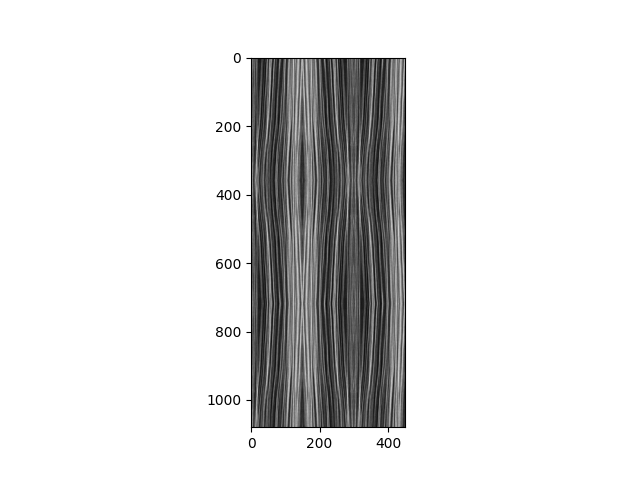

In [46]:
fig, ax = plt.subplots()
ax.imshow(tiling_for_fourrier,cmap="gray")


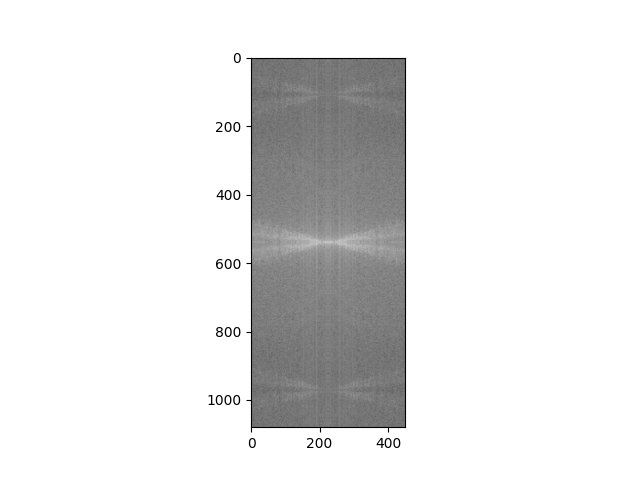

In [47]:
dark_image_grey_fourier = np.fft.fftshift(np.fft.fft2(tiling_for_fourrier))
fig, ax = plt.subplots()
ax.imshow(np.log(np.abs(dark_image_grey_fourier)),cmap="gray")

In [48]:
coordinates_middle = np.array(dark_image_grey_fourier.shape)//2

In [49]:
LT_quadrant = np.s_[:coordinates_middle[0],:coordinates_middle[1]]
LB_quadrant = np.s_[coordinates_middle[0]+1:,:coordinates_middle[1]]
RB_quadrant = np.s_[coordinates_middle[0]+1:,coordinates_middle[1]:]
RT_quadrant = np.s_[:coordinates_middle[0],coordinates_middle[1]:]


In [50]:
# filtered_fourrier = 0*dark_image_grey_fourier
# filtered_fourrier[LT_quadrant] = dark_image_grey_fourier[LT_quadrant]
# filtered_fourrier[RB_quadrant] = dark_image_grey_fourier[RB_quadrant]

In [51]:
filtered_fourrier  = dark_image_grey_fourier
filtered_fourrier[LT_quadrant] = 0
filtered_fourrier[RB_quadrant] = 0

In [52]:
LT_quadrant

(slice(None, 540, None), slice(None, 225, None))

C:\Users\coren\AppData\Local\Temp\ipykernel_16124\3043536324.py:2: RuntimeWarning: divide by zero encountered in log
  ax.imshow(np.log(np.abs(filtered_fourrier)),cmap="gray")


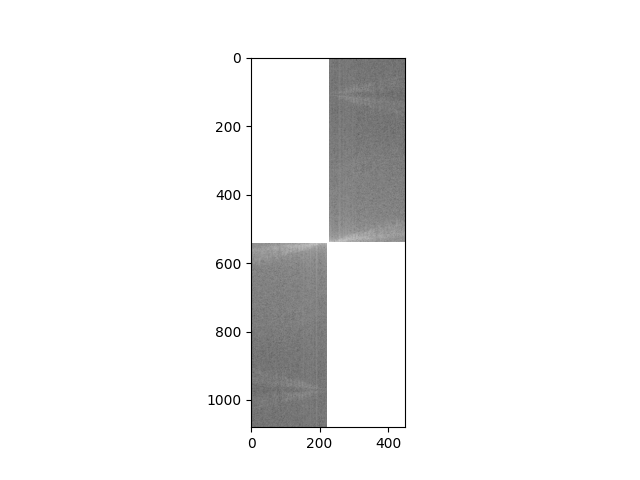

In [53]:
fig, ax = plt.subplots()
ax.imshow(np.log(np.abs(filtered_fourrier)),cmap="gray")

C:\Users\coren\AppData\Local\Temp\ipykernel_16124\136044531.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


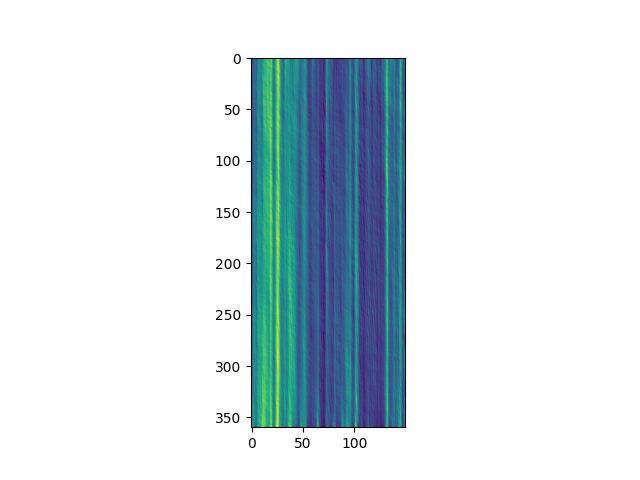

In [54]:
filtered = np.fft.ifft2(filtered_fourrier)
fig, ax = plt.subplots()
shape_v,shape_h = filtered.shape
shape_v,shape_h = shape_v//3,shape_h//3
middle_slice = np.s_[shape_v:2*shape_v,shape_h:2*shape_h]
middle = filtered[middle_slice]
ax.imshow(np.abs(middle))
# ax.imshow(np.abs(filtered),cmap='gray')

In [55]:
A

array([[42.3, 30.3, 20.6, ..., 53.1, 30.6, 37.7],
       [42.3, 30.3, 20.6, ..., 53.1, 30.6, 37.7],
       [41.9, 27.8, 21.1, ..., 48.4, 27.5, 37.1],
       ...,
       [82.3, 75.1, 58.9, ..., 22.8, 27.1, 49.8],
       [84.2, 76.5, 58.5, ..., 18.4, 27.9, 50.5],
       [84.2, 76.5, 58.5, ..., 18.4, 27.9, 50.5]])

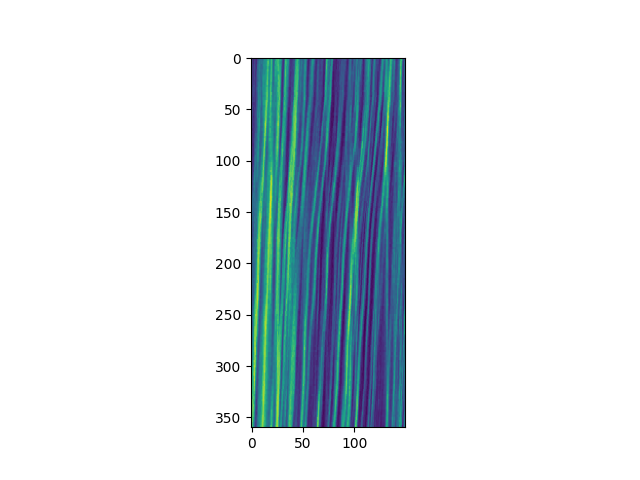

In [56]:
fig, ax = plt.subplots()
ax.imshow(A)

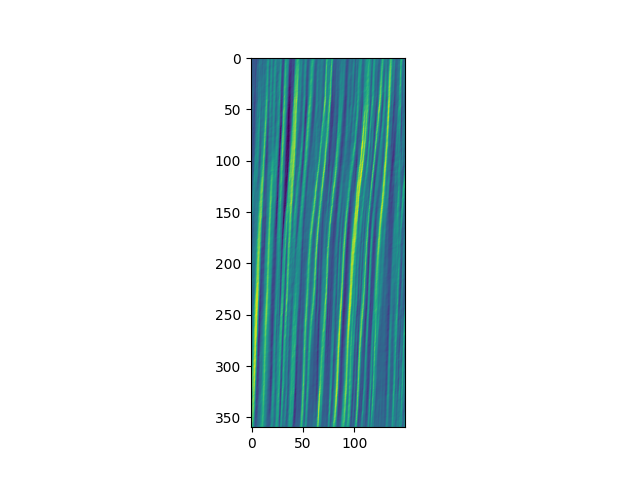

In [57]:
fig, ax = plt.subplots()
ax.imshow(A-np.abs(middle))

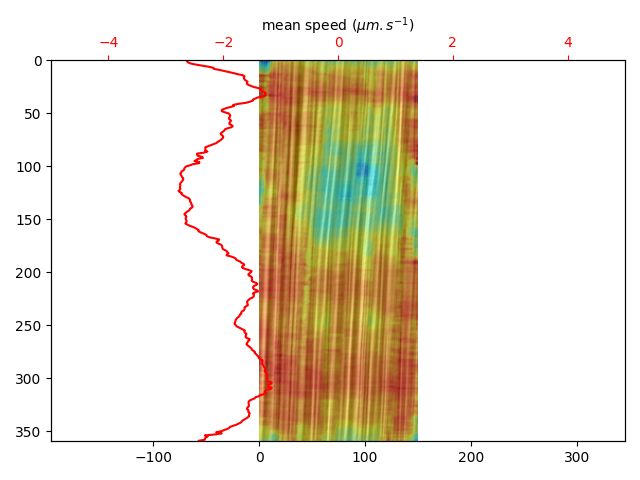

In [61]:
W = 15
C_Thr = 0.7
imgcrop = A-np.abs(middle)
imgCoherency, imgOrientation = calcGST(imgcrop, W)
nans = np.empty(imgOrientation.shape)
nans.fill(np.nan)
real_movement = np.where(imgCoherency>C_Thr,imgOrientation,nans)

speeds = np.tan((np.nanmean(real_movement,axis=1)-90)/180*np.pi)*space_pixel_size/time_pixel_size #um.s-1
nans = np.empty(speeds.shape)
nans.fill(np.nan)
speeds = np.where(speeds<20,speeds,nans)
nans = np.empty(speeds.shape)
nans.fill(np.nan)
speeds = np.where(speeds>-20,speeds,nans)
y= speeds
nans, x= nan_helper(y)
y[nans]= np.interp(x(nans), x(~nans), y[~nans])
speeds=y
fig, ax = plt.subplots()
ax.imshow(imgcrop,cmap="gray")
ax2 = ax.twiny()
# ax2.plot(np.tan((np.mean(imgOrientation,axis=1)-90)/180*np.pi),range(len(np.mean(imgOrientation,axis=1))),color = "red")
ax2.plot(speeds,range(len(speeds)),color = "red")

ax2.tick_params(axis='x', colors='red')
ax2.set_xlabel('mean speed ($\mu m.s^{-1}$)')

ax.imshow(imgOrientation*(imgCoherency>C_Thr),alpha=0.5,cmap="jet")
ax2.set_xlim((-5,5))

plt.tight_layout()

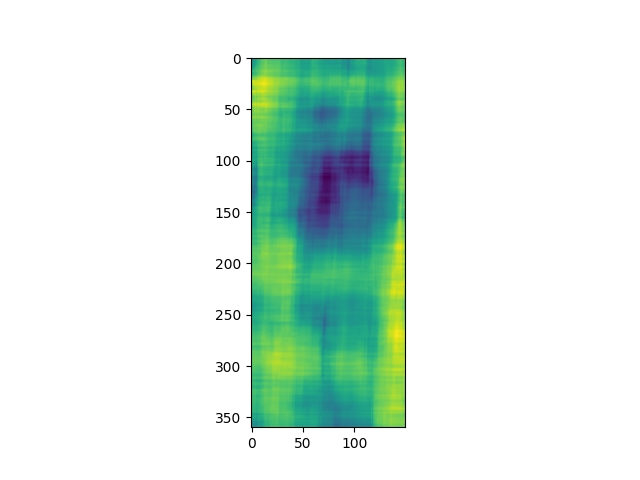

In [75]:
speeds = np.tan((real_movement-90)/180*np.pi)*space_pixel_size/time_pixel_size #um.s-1

In [76]:
from scipy import signal
to_treat = (speeds-np.mean(speeds))/np.std(speeds)
corr = signal.correlate2d(to_treat, to_treat,mode='same',boundary="symm")
corr = corr/np.max(corr)

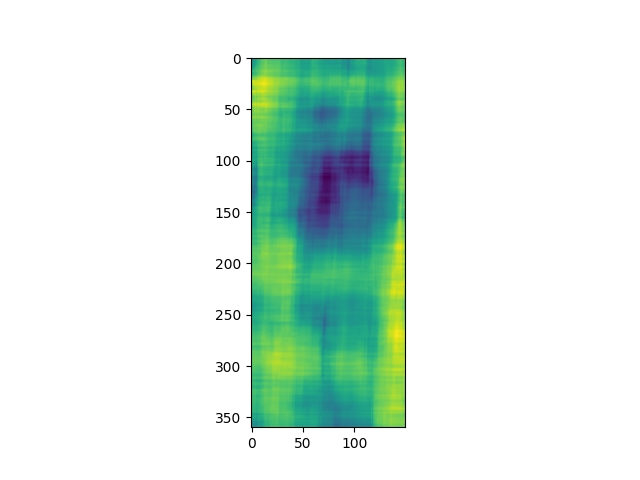

In [77]:
fig, ax = plt.subplots()
ax.imshow(to_treat)

Text(0, 0.5, 'time')

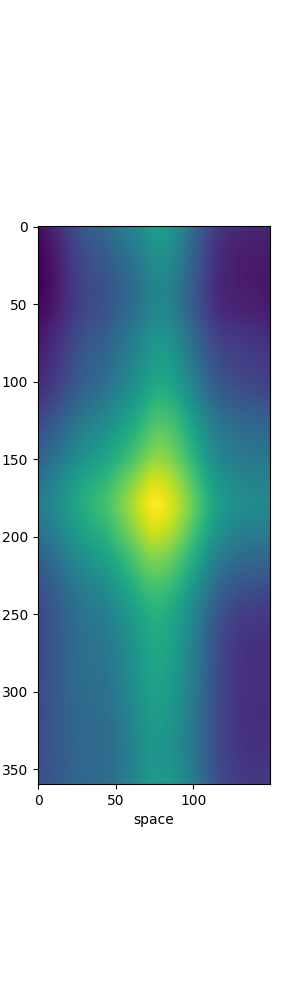

In [79]:
fig, ax = plt.subplots(figsize=(3,10))
ax.imshow(corr)
ax.set_xlabel('space')
ax.set_ylabel('time')

In [80]:
def get_length_um_edge(edge, nx_graph):
    pixel_conversion_factor = space_pixel_size
    length_edge = 0
    pixels = nx_graph.get_edge_data(*edge)['pixel_list']
    for i in range(len(pixels) // 10 + 1):
        if i * 10 <= len(pixels) - 1:
            length_edge += np.linalg.norm(
                np.array(pixels[i * 10])
                - np.array(pixels[min((i + 1) * 10, len(pixels) - 1)])
            )
    #             length_edge+=np.linalg.norm(np.array(pixels[len(pixels)//10-1*10-1])-np.array(pixels[-1]))
    return length_edge * pixel_conversion_factor

In [81]:
length_edge = get_length_um_edge(edge,nx_graph_pruned)

Text(0, 0.5, 'correlation')

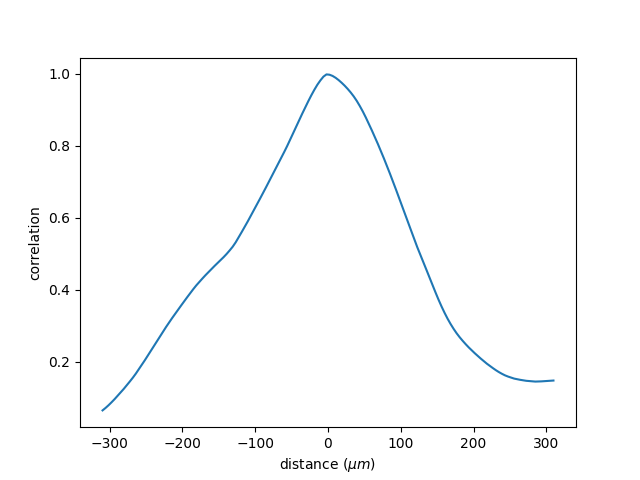

In [85]:
spatial_corr = corr[corr.shape[0]//2,:]
fig, ax = plt.subplots()
length_space= length_edge
xs = np.linspace(-length_space/2,length_space/2,len(spatial_corr))
ax.plot(xs,spatial_corr)
ax.set_xlabel('distance ($\mu m$)')
ax.set_ylabel('correlation')

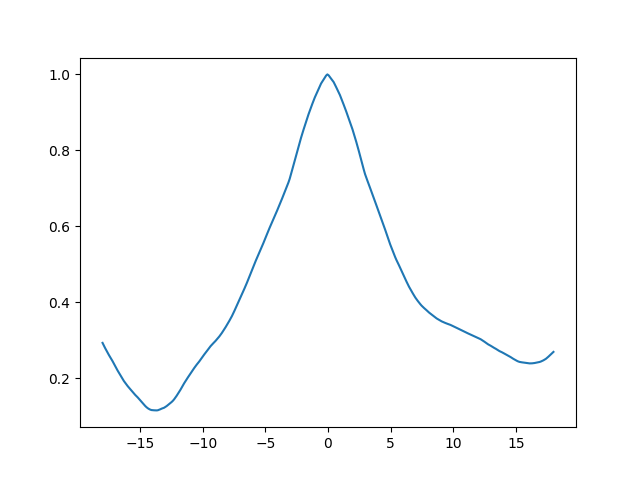

In [83]:
time_corr = corr[:,corr.shape[1]//2]
fig, ax = plt.subplots()
length_time= time_pixel_size*len(time_corr)
ts = np.linspace(-length_time/2,length_time/2,len(time_corr))
ax.plot(ts,time_corr)

In [ ]:
time_corr = np.mean(corr,axis=1)
fig, ax = plt.subplots()
length_time= time_pixel_size*len(time_corr)
ts = np.linspace(-length_time/2,length_time/2,len(time_corr))
ax.plot(ts,time_corr)

In [ ]:
corr = np.load('correlation.npy')

In [ ]:
fig, ax = plt.subplots(figsize=(3,15))
ax.imshow(corr)


In [ ]:
corr.shape

In [ ]:
time_pixel_size = 0.1
fig, ax = plt.subplots()
max_space_corr = np.argmax(corr,axis=1)
length_time= time_pixel_size*len(max_space_corr)
ts = np.linspace(-length_time/2,length_time/2,len(max_space_corr))
plt.scatter(ts,max_space_corr)

In [ ]:
max_time_corr

In [ ]:
space_pixel_size = 1.725*2
fig, ax = plt.subplots()
max_time_corr = np.argmax(corr,axis=0)*time_pixel_size-length_time/2
length_space= space_pixel_size*len(max_time_corr)
xs = np.linspace(-length_space/2,length_space/2,len(max_time_corr))
plt.scatter(xs,max_time_corr)
ax.set_ylim(-10,10)
ax.set_xlabel('distance ($\mu m)$')
ax.set_ylabel('time_shift with the peak of correlation (s)')